Creating the Initial Conditions for our BH/DM Halo Simulation!

In [1]:
import scipy.stats as st
import numpy as np
import random

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from math import isnan
from math import gamma
from astropy import units as u
from astropy import constants as c

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
G        = c.G
m_1      = 10**4 *(u.solMass)

rho_sp   = 226 *(u.solMass/(u.parsec**3))
gamma_sp = 2 # Dimensionless slope parameter.

r_in     = 1.914*10**-9 *(u.parsec)
r_sp     = 1.17097 *(u.parsec)

In [3]:
unit_energy = (u.solMass*u.parsec**2*u.s**-2)

In [4]:
def inverse_cdf(F):
    r = (r_sp**(-gamma_sp)*
         (F*r_sp**3+r_in**3*(r_sp/r_in)**gamma_sp-F*r_in**3*(r_sp/r_in)**gamma_sp))**(1/(3-gamma_sp))
    return r

In [5]:
def random_radius(sample):
    F = np.random.uniform(size=sample)
    return inverse_cdf(F)

In [6]:
def random_vector():
    vector            = np.asarray([np.random.normal() for _ in range(3)])
    normalized_vector = vector / np.linalg.norm(vector)
    rand = random_radius(1)[0]
    return normalized_vector * random_radius(1)[0]

Vector: [ 0.23353217 -0.56544041  0.93850679] pc
Wall time: 1.36 s


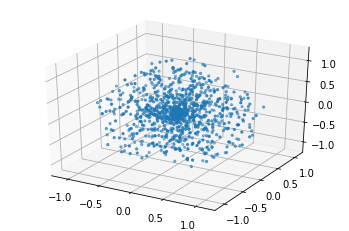

In [7]:
%%time
example_vector = random_vector()
print('Vector:', example_vector)

zdata = []
ydata = []
xdata = []

vectors = []
for i in range(1000):
    vectors.append(random_vector())

for vector in vectors:
    xdata.append(vector[0]/u.parsec)
    ydata.append(vector[1]/u.parsec)
    zdata.append(vector[2]/u.parsec)

ax = plt.axes(projection='3d')
ax.scatter3D(xdata,ydata,zdata,s=5);

Let's randomize the velocities of each DM particle!

In [8]:
def number_per_energy(epsilon):
    num_particle_density =                                         \
    (G**3)*(np.pi**(3/2))*(epsilon**(gamma_sp-4))*(m_1**3)         \
    *((r_sp/(G*m_1))**gamma_sp)*(gamma_sp-1)*(gamma_sp)*(rho_sp)   \
    *gamma(gamma_sp-1)
    
    num_particle_density /= (gamma(gamma_sp-(1/2)))
    return num_particle_density

In [9]:
def normalization(epsilon_min,epsilon_max):
    norm =                                               \
    (G**3)*(np.pi**(3/2))*(m_1**3)                       \
    *((r_sp/(G*m_1))**gamma_sp)*(gamma_sp-1)*(gamma_sp)  \
    *((-epsilon_max**(gamma_sp))*(epsilon_min**3)        \
    +(epsilon_max**3)*epsilon_min**(gamma_sp))*(rho_sp)  \
    *gamma(gamma_sp-1)
    
    norm /= ((gamma_sp-3)*(gamma(gamma_sp-(1/2))))*(epsilon_max**3)*(epsilon_min**3)
    return norm            

In [10]:
epsilon_unit = (u.solMass/u.parsec)*(u.meter**3/(u.kg*u.second**2))

epsilon_min = (G*m_1)/(10*r_sp)
# Some outer radius threshold, we define to be ~10*r_sp.
epsilon_max = (G*m_1)/(10*r_in)
# Some inner radius threshold, we define to be ~10*r_in.

norm = normalization(-epsilon_min/unit_energy,-epsilon_max/unit_energy)
print(norm)

45599.03044368055 pc2 solMass2 / s2


Let's work some magic with icdf generation and sampling!

In [11]:
def sample_cdf(pdf, xmin, xmax, n_bins=1000, log=False):
    if log:
        binner = np.geomspace
    else:
        binner = np.linspace
    edges = binner(xmin, xmax, n_bins)
    bins = np.vstack((edges[:-1], edges[1:])).T
    centers = np.mean(bins, axis=1)
    widths = bins[:, 1] - bins[:, 0]
    pdf_samples = pdf(centers)
    cdf_samples = np.cumsum(pdf_samples * widths)
    cdf_samples /= cdf_samples[-1]
    return np.vstack((centers, cdf_samples)).T

def inverse_CDF(*args, **kwargs):
    iy, ix = sample_cdf(*args, **kwargs).T
    return interp1d(ix, iy, fill_value='extrapolate')

def sample(icdf, n_samples):
    range_samples = np.random.uniform(size=n_samples)
    return icdf(range_samples)

Now, we can apply these functions to our normalized number-per-energy(epsilon) function:

In [12]:
%%time
def norm_num_per_energy(e):
    num = number_per_energy(e)/norm
    return num

icdf = inverse_CDF(norm_num_per_energy, epsilon_min/epsilon_unit, epsilon_max/epsilon_unit)

def random_energy(size):
    samples = sample(icdf, size)
    return samples * unit_energy

Wall time: 3 ms


### Testing

In [84]:
# So this seems to work out, without issue!?

random_energy(1)
r = 1*u.parsec
m,e = rand_velocity(r)
speed = u.parsec/u.second

grav_potential(r).to(unit_energy)
m.to(speed)

<Quantity 0.00732399 pc / s>

### Important to think about the m<sub>2</sub> factor in gravitational potential, and later divide to get velocity.

Here, we quickly generate a random set of unit vectors for the velocity's direction:

In [13]:
# This is very similar to the previous function for generating random vectors, but without the random radius.
def random_unit_vector(num):
    arr = np.random.normal(size=num*3).reshape((num,3))
    arr /= np.linalg.norm(arr,axis=1)[:,np.newaxis]
    return arr

In [85]:
# Here's the gravitational potential as defined in the paper.
def grav_potential(r):
    psi = (G*m_1)/(r) * u.solMass
    return -psi

# We obtain the velocity through another equation defined in the paper (4.1)
def rand_velocity(r):
        randE = random_energy(1)[0]
        magnitude = (2*(grav_potential(r)-randE)/m_1)**(1/2)
        return magnitude, randE

In [41]:
def rand_vect_gen(num):
    for i in range(num):
        cartesian = random_vector()                # Generate num amount of position vectors, save the radius.
        positions[i,:] = (cartesian)               # We append the (x,y,z) coord's to our position list.
    radii = np.linalg.norm(positions,axis=1)
    return positions,radii

### Testing

In [126]:
print('gravitational potential',grav_potential(random_vector()[0]).to(unit_energy))
print('random energy: ',random_energy(1)[0])

m,e = rand_velocity(r=1*u.parsec)
m.to(speed)

gravitational potential -1.2840049354052332e-25 pc2 solMass / s2
random energy:  -0.13117088484235156 pc2 solMass / s2


<Quantity 0.00280845 pc / s>

Then, for some number of particles, we generate a velocity direction and magnitude:

In [134]:
%%time
# Number of particles to generate positions and velocity vectors for.
num = 10

# We initialize lists for position vectors and a list of respective radii generated from previous functions.
positions       = np.zeros((num,3))

positions,radii = rand_vect_gen(num)

velocities      = random_unit_vector(num)                 # Generate some num amount of velocity unit vectors.

complexList     = np.zeros((num,3))
energyList      = np.zeros((num,1))

# Set an arbitrary indexing counter, i.
for i, particle in enumerate(velocities):
    r                 = radii[i]*u.parsec                        # We find the corresponding radius for our i'th particle.
    magnitude, energy = rand_velocity(r)
    magnitude         = magnitude.to(speed)
    
    energyList[i,:]   = (energy)
    particle_new      = particle * magnitude             # Update the particle's velocity vector.
    
    if isnan(particle_new[0]/speed):
        # We identify the particles with complex velocities.
        complexList[i,:] = (particle)
        
    velocities[i]     = particle_new                     # Set the i'th velocities vector to this updated vector.
    
    
# Now, we should have a list of velocity vectors with random direction and magnitude based on energies->radii/pos.
    
print(velocities*speed)
print(positions*u.parsec)
    
i = 0
for item in velocities:
    if isnan(item[0]):
        i += 1
print('\nThere are ',i,'cases where the velocity is NaN!')
print('This means: ',(i/num)*100,'% of the particles generated could not have a velocity.\n')
    
print(complexList)
print(energyList)
# Only NaN when the energy is a positive value?????
# Because it would become repulsive and tend to eject from orbit

# looking good, need to confirm that grav and random e are on same order, and that the m_2 of the particles
# is factored in correctly. 
# Then we can see if any particles would become viable if swapped between elements.

[[ 0.0039274   0.00246892 -0.00173269]
 [ 0.00109523  0.00120093  0.00260488]
 [-0.00029335 -0.00010093  0.00065144]
 [ 0.00583914 -0.00303755 -0.00182216]
 [ 0.00136226 -0.00330236  0.0037573 ]
 [-0.0040651   0.00191222  0.00202962]
 [ 0.00458426  0.00282746  0.0036811 ]
 [        nan         nan         nan]
 [-0.00153641  0.00650379  0.00274862]
 [ 0.00657072  0.00165885 -0.00216314]] pc / s
[[-0.09746006 -0.20992571  0.74955624]
 [-0.36501847  0.09478433 -0.171218  ]
 [ 0.33073368 -0.32839775 -0.29498651]
 [-0.21260702  0.09567159  0.4801992 ]
 [ 0.97893893  0.30442928  0.01051443]
 [ 0.19536204  0.18261943  0.48398034]
 [ 0.1085859   0.04393549 -0.7914624 ]
 [ 0.0222199   0.01940296  0.00715484]
 [ 0.16292888 -1.0473789  -0.2751579 ]
 [ 0.65934075  0.35672719 -0.23123134]] pc

There are  1 cases where the velocity is NaN!
This means:  10.0 % of the particles generated could not have a velocity.

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.   